## GAN: MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data

In [3]:
import os
import gzip

def load_mnist_images(data_dir, filename):
    data_path = os.path.join(data_dir, filename)
    with gzip.open(data_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28, 28)

def load_mnist_labels(data_dir, filename):
    data_path = os.path.join(data_dir, filename)
    with gzip.open(data_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

# data_dir = r"D:\datasets\mnist_11M"   ## windows
data_dir = "/mnt/d/datasets/mnist_11M"  ## wsl

x_train = load_mnist_images(data_dir, "train-images-idx3-ubyte.gz")
y_train = load_mnist_labels(data_dir, "train-labels-idx1-ubyte.gz")
x_test = load_mnist_images(data_dir, "t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels(data_dir, "t10k-labels-idx1-ubyte.gz")

print(f">> Train images: {x_train.shape}, {x_train.dtype}")
print(f">> Train labels: {y_train.shape}, {y_train.dtype}")
print(f">> Test images:  {x_test.shape}, {x_test.dtype}")
print(f">> Test labels:  {y_test.shape}, {y_test.dtype}")

>> Train images: (60000, 28, 28), uint8
>> Train labels: (60000,), uint8
>> Test images:  (10000, 28, 28), uint8
>> Test labels:  (10000,), uint8


In [4]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class MNIST(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.reshape(-1, 28, 28, 1)
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label).long()
        return image, label

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

train_loader = DataLoader(MNIST(x_train, y_train, transform=transform), 
                          batch_size=64, shuffle=True)
test_loader = DataLoader(MNIST(x_test, y_test, transform=transform), 
                         batch_size=64, shuffle=True)

x, y = next(iter(train_loader))
print(f">> x: {x.shape}, {x.dtype}, min={x.min()}, max={x.max()}")
print(f">> y: {y.shape}, {y.dtype}, min={y.min()}, max={y.max()}")

>> x: torch.Size([64, 1, 28, 28]), torch.float32, min=-1.0, max=1.0
>> y: torch.Size([64]), torch.int64, min=0, max=9


/home/nam/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


### Modeling

In [7]:
class Generator(nn.Module):
    def __init__(self, input_size, output_size, n_classes, bias=True):
        super().__init__()
        self.n_classes = n_classes
        self.embedding_dim = 16
        self.embedding = nn.Embedding(self.n_classes, self.embedding_dim)
        self.generator = nn.Sequential(
            nn.Linear(input_size + self.embedding_dim, 256, bias=bias),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256, bias=bias),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256, bias=bias),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, output_size, bias=bias),)

    def forward(self, noises, labels):
        labels_embedding = self.embedding(labels)
        inputs = torch.cat([noises, labels_embedding], dim=1)
        images = self.generator(inputs)
        images = images.view(-1, 1, 28, 28)
        return torch.tanh(images)

class Discriminator(nn.Module):
    def __init__(self, input_size, output_size, n_classes, bias=True):
        super().__init__()
        self.n_classes = n_classes
        self.embedding_dim = 16
        self.embedding = nn.Embedding(self.n_classes, self.embedding_dim)
        self.discriminator = nn.Sequential(
            nn.Linear(input_size + self.embedding_dim, 256, bias=bias),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 256, bias=bias),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 256, bias=bias),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, output_size, bias=bias),)

    def forward(self, images, labels):
        images = images.view(-1, 28*28)
        labels_embedding = self.embedding(labels)
        inputs = torch.cat([images, labels_embedding], dim=1)
        outputs = self.discriminator(inputs)
        return torch.sigmoid(outputs)

### Training

In [8]:
import sys
from torchvision.utils import save_image
from tqdm import tqdm

## Hyperparameters
set_seed(42)
n_epochs = 10
learning_rate = 2e-4
step_size = 2
noise_size = 64

n_classes = 10
n_outputs = 100
output_name = "mnist_cgan_mlp_embedding"

## Modeling
modelG = Generator(input_size=noise_size, output_size=28*28, n_classes=n_classes).to(device)
modelD = Discriminator(input_size=28*28, output_size=1, n_classes=n_classes).to(device)

loss_fn = nn.BCELoss()
optimizerD = optim.Adam(modelD.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizerG = optim.Adam(modelG.parameters(), lr=learning_rate, betas=(0.5, 0.999))

## Training
fixed_noises = torch.randn(n_outputs, noise_size).to(device)
fixed_labels = torch.arange(n_classes).repeat(n_outputs // n_classes, 1).view(-1).to(device)
output_dir = '/mnt/d/github/lectures-1/test/mnist/output_cgan'
output_images = modelG(fixed_noises, fixed_labels)
output_path = os.path.join(output_dir, f"{output_name}_0.png")
save_image(output_images, output_path, nrow=10, normalize=True)

In [9]:
for epoch in range(1, n_epochs + 1):
    with tqdm(train_loader, leave=False, file=sys.stdout, dynamic_ncols=True, ascii=True) as pbar:
        train_loss_r, train_loss_f, train_loss_g = 0, 0, 0
        for i, (real_images, labels) in enumerate(pbar):
            batch_size = len(real_images)
            real_labels = torch.ones((batch_size, 1)).to(device)
            fake_labels = torch.zeros((batch_size, 1)).to(device)
            noises = torch.randn(batch_size, noise_size).to(device)
            real_images = real_images.to(device)
            labels = labels.to(device)
            fake_images = modelG(noises, labels)

            ## Training Discriminator
            pred_r = modelD(real_images, labels)
            loss_r = loss_fn(pred_r, real_labels)
            loss_r.backward()

            pred_f = modelD(fake_images.detach(), labels)
            loss_f = loss_fn(pred_f, fake_labels)
            loss_f.backward()

            optimizerD.step()
            optimizerD.zero_grad()

            # Training Generator
            pred_g = modelD(fake_images, labels)
            loss_g = loss_fn(pred_g, real_labels)
            loss_g.backward()

            optimizerG.step()
            optimizerG.zero_grad()
            
            train_loss_r += loss_r.item()
            train_loss_f += loss_f.item()
            train_loss_g += loss_g.item()

            desc = f"[{epoch:3d}/{n_epochs}] loss_r: {train_loss_r/(i + 1):.2e} " \
                   f"loss_f: {train_loss_f/(i + 1):.2e} loss_g: {train_loss_g/(i + 1):.2e}"

            if i % 10 == 0:
                pbar.set_description(desc)

        if epoch % step_size == 0:
            print(desc)
            output_images = modelG(fixed_noises, fixed_labels)
            output_path = os.path.join(output_dir, f"{output_name}_{epoch}.png")
            save_image(output_images, output_path, nrow=10, normalize=True)

[  2/10] loss_r: 2.51e-01 loss_f: 9.93e-01 loss_g: 5.20e-01                                                   
[  4/10] loss_r: 3.05e-01 loss_f: 1.03e+00 loss_g: 4.85e-01                                                   
[  6/10] loss_r: 3.44e-01 loss_f: 1.07e+00 loss_g: 4.57e-01                                                   
[  8/10] loss_r: 3.61e-01 loss_f: 1.08e+00 loss_g: 4.45e-01                                                   
[ 10/10] loss_r: 3.72e-01 loss_f: 1.09e+00 loss_g: 4.36e-01                                                   


## Evaluation

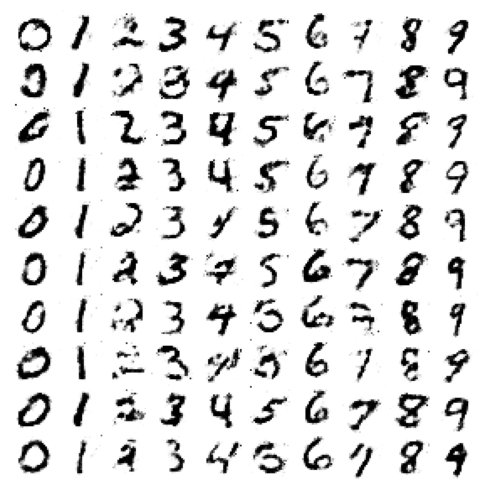

In [36]:
# set_seed(111)
fixed_noises = torch.randn(n_outputs, noise_size).to(device)
fixed_labels = torch.arange(n_classes).repeat(n_outputs // n_classes, 1).view(-1).to(device)
with torch.no_grad():
    output_images = modelG(fixed_noises, fixed_labels)

images = output_images.cpu().detach().numpy().transpose(0, 2, 3, 1).squeeze()
rows = [np.concatenate(images[i*10:(i+1)*10], axis=1) for i in range(10)]
grid = np.concatenate(rows, axis=0)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(grid, cmap="gray_r")
ax.set_axis_off()
fig.tight_layout()
plt.show()